# Uploading data

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs

#### File nomenclature
import _epo.fif files
    
    format: "g"+ group_number + player_type + subject +'_epo.fif'
    player_type: ["solo", "dual"]
    subject: [1, 2]

In [3]:
url = './data/'

print("\n========= epoch_1 ==========")

# epoch_1
file_name_1 = 'g1dual1_epo.fif' # eg. 'g1dual1_epo.fif'
epoch_1 = read_epochs(url + file_name_1)
print("\n========= epoch_2 ==========")

# epoch_2
file_name_2 = 'g1solo1_epo.fif' # eg. 'g1dual2_epo.fif'
epoch_2 = read_epochs(url + file_name_2)


========= epoch_1 ==========
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated

========= epoch_2 ==========
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [4]:
X_train = epoch_1.get_data()
y_train = np.array(epoch_1.events[:, -1], dtype = 'float32')

print(X_train.shape)
print(y_train.shape)

(636, 32, 410)
(636,)


In [5]:
X_val = epoch_2.get_data()
y_val = np.array(epoch_2.events[:, -1], dtype = 'float32')

print(X_val.shape)
print(y_val.shape)

(240, 32, 410)
(240,)


#### Creating Tensors

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
X = torch.Tensor(X_train)
y = torch.Tensor(y_train)
y = y-1
y = y.unsqueeze(1)
print(X.size())
print(y.size())

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
y_val = y_val-1
y_val = y_val.unsqueeze(1)
print(X_val.size())
print(y_val.size())

torch.Size([636, 32, 410])
torch.Size([636, 1])
torch.Size([240, 32, 410])
torch.Size([240, 1])


In [8]:
train_ds = TensorDataset(X, y)
valid_ds = TensorDataset(X_val, y_val)

# train_size = int(X.size()[0] * 0.8)
# valid_size = X.size()[0] - train_size

# train_set, valid_set = torch.utils.data.random_split(train_ds, [train_size, valid_size])

BATCH_SIZE= 64

train_iterator = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

#### Model

In [9]:
class CNN(nn.Module):
    def __init__(self,num_classes, input_shape):
        super(CNN, self).__init__()
        self.input_dim = input_shape[1]
        self.input_samples = input_shape[2]
        
        #Layer 0
        self.layer0 = nn.BatchNorm1d(32)
        
        #Layer 1
        self.layer1 = nn.Sequential(nn.BatchNorm1d(32),
                    nn.Conv1d(in_channels= 32, out_channels= 16, kernel_size = 1, stride=1),
                    nn.ReLU())
        
        #Layer2
        self.layer2 = nn.Sequential(nn.BatchNorm1d(16),
                    nn.Conv1d(in_channels= 16, out_channels= 16 , kernel_size = 20, stride = 20),
                    nn.ReLU())
        
        #Layer3
        self.fc1 = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear( 16 * round(self.input_samples/ 20), 128),
                    nn.Tanh(),
                    nn.Dropout(p=0.8))
        #Layer4
        self.fc2 = nn.Sequential(
                    nn.Linear(128 , 128),
                    nn.Tanh(),
                    nn.Dropout(p=0.8))
        
        #Layer5
        self.fc3 = nn.Sequential(nn.Linear(128 , num_classes),nn.Sigmoid())
    
    
    def forward(self, x):
        x = self.layer0(x)
#         print("l0 out",x.size())
        x = self.layer1(x)
#         print("l1 out",x.size())
        x = self.layer2(x)
#         print("l2 out",x.size())
        x = self.fc1(x)
#         print("l3 out",x.size())
        x = self.fc2(x)
#         print("l4 out",x.size())
        x = self.fc3(x)
#         print("l5 out",x.size())
        return x

In [10]:
learning_rate=0.001
epoches = 50
input_shape = X_train.shape
print(input_shape)

(636, 32, 410)


In [11]:
model = CNN(num_classes=1, input_shape = input_shape).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print(model)

CNN(
  (layer0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=128, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.8, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.8, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [13]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
       # print("predictions",predictions)
        #print("labels", labels)
        predicted = predictions.round()
#         print("train predicted",predicted)
#         _, predicted = torch.max(predictions.data, 1) 
        #returns max value, indices
#         predicted = predicted.unsqueeze(1)
        total += labels.size(0)  #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
        correct += (predicted == labels).sum().item()
#         print("label",labels.size())
#         print("predicted", predicted.size())
#         print("correct", correct)
#         print("total", total)
#         print("acc", correct/ total)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
            print("test predicted",predicted.T)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [14]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Train, validation

In [15]:
N_EPOCHS = 12

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

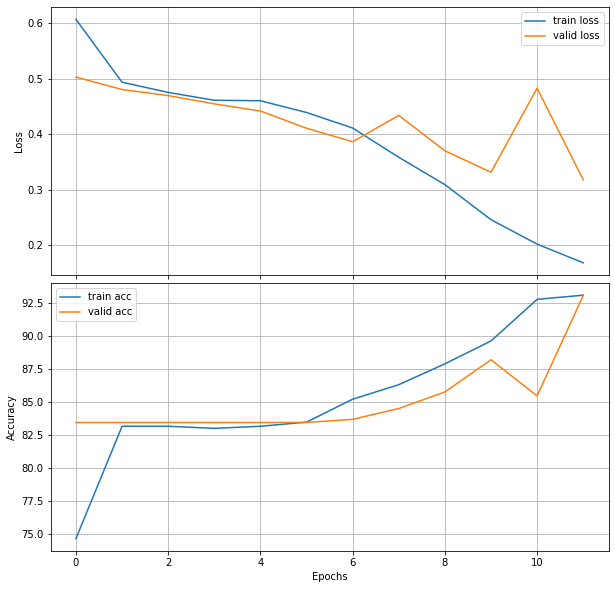

In [16]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## Test on different subject

### testing - subjects (1 to 19) 

In [17]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
#             print("test predicted",predicted.T)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [18]:
subject_no = 1
val_acc_list = []
subject_no_list = []

for i in range(1, 20):
    for j in range(1,3):
        print("Subject No:", subject_no)
        subject_no_list.append(subject_no)
        subject_no += 1
        
        print(f"g{i}dual{j}_epo.fif")
        print(f"g{i}solo{j}_epo.fif")
        test_file_1 = 'g'+str(i)+'dual'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_1 = read_epochs(url + test_file_1)
        test_file_2 = 'g'+str(i)+'solo'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_2 = read_epochs(url + test_file_2)

        X_test1 = epoch_1.get_data()
        y_test1 = np.array(epoch_1.events[:, -1], dtype = 'float32')

        X_test2 = epoch_2.get_data()
        y_test2 = np.array(epoch_2.events[:, -1], dtype = 'float32')

        X_test = np.concatenate((X_test1, X_test2), axis=0)
        y_test = np.concatenate((y_test1, y_test2), axis=0)
        # print(X_train.shape)
        # print(y_train.shape)

        X_test = torch.Tensor(X_test)
        y_test = torch.Tensor(y_test)
        y_test = y_test-1
        y_test = y_test.unsqueeze(1)
        # print(X_val.size())
        # print(y_val.size())

        test_ds = TensorDataset(X_test, y_test)

        BATCH_SIZE= 64

        test_iterator = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

        test_losses = []
        test_accs = []
        test_predicted_labels = []
        best_test_loss = float("inf")

        # for epoch in range(N_EPOCHS):
        start_time = time.time()

        test_loss, test_acc, predicted_test_eval = evaluate(model, test_iterator, criterion)

        test_losses.append(test_loss); test_accs.append(test_acc); test_predicted_labels.append(predicted_test_eval)
        
        val_acc_list.append(test_acc)
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # if (epoch+1) % 5 == 0:
        # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f}%')
        print("================================================")
        print("================================================")
        print("================================================")

        #         print(predicted_train)
        #         print(predicted_eval)

        # if test_loss < best_test_loss:
        #     best_test_loss = test_loss
        #         print("Model:{} saved.".format(type(model).__name__))
        #         torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
        #         4best_model_index = i

Subject No: 1
g1dual1_epo.fif
g1solo1_epo.fif
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.220 |  Test. Acc: 92.74%
Subject No: 2
g1dual2_epo.fif
g1solo2_epo.fif
Reading ./data/g1dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo

Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.597 |  Test. Acc: 84.11%
Subject No: 12
g6dual2_epo.fif
g6solo2_epo.fif
Reading ./data/g6dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correct

        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.745 |  Test. Acc: 83.20%
Subject No: 22
g11dual2_epo.fif
g11solo2_epo.fif
Reading ./data/g11dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g11solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.711 |  Test. Acc: 83.96%
Subject No: 23
g12dual1_epo.fif
g12solo1_epo.fif
Reading ./data/g12dual1_epo.fif ...
    Found the data of interest:
        t = 

	 Test. Loss: 0.678 |  Test. Acc: 84.22%
Subject No: 32
g16dual2_epo.fif
g16solo2_epo.fif
Reading ./data/g16dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g16solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.761 |  Test. Acc: 81.60%
Subject No: 33
g17dual1_epo.fif
g17solo1_epo.fif
Reading ./data/g17dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied


In [19]:
import xlsxwriter

workbook = xlsxwriter.Workbook('BN3 Conv1D+LSTM Test with another subj.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0, 'Subject No')
worksheet.write(0, 1, 'Val Accuracy')

for i in range(len(subject_no_list)):
    worksheet.write(i+1, 0, subject_no_list[i])
    worksheet.write(i+1, 1, val_acc_list[i])
    
workbook.close()